In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [34]:
def MMETSP_groupby(df, level='Division', normalized=True):
    division_MMETSP = df.merge(mmetsp_taxonomy[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = mmetsp_taxonomy.groupby(level)['Notes'].count()
    if normalized:
        division_MMETSP = division_MMETSP.T/total_per_group
        division_MMETSP = division_MMETSP.T
    return(division_MMETSP, total_per_group)

def create_cluster_bar(grouped_MMETSP, total_per_group, size=[12,12],
                       cutoff=False, c=5, genome=False, dropzero=False):
    grouped_MMETSP=grouped_MMETSP.dropna()
    if cutoff: 
        ii=total_per_group>c
        grouped_MMETSP= grouped_MMETSP.loc[ii]
        total_per_group=total_per_group[ii]
    if dropzero:
        ss= grouped_MMETSP[grouped_MMETSP.sum(axis=1)>0].index
        print(ss)
        grouped_MMETSP = grouped_MMETSP.loc[ss]
        total_per_group=total_per_group[ss]
    cluster = sns.clustermap(grouped_MMETSP, cmap='binary', yticklabels=1)
    cluster.fig.set_size_inches(size)
    
    # make some space to the right in the figure
    cluster.gs.update(right=0.95)
    # divide existing axes
    divider = make_axes_locatable(cluster.ax_heatmap)
    divider2 = make_axes_locatable(cluster.ax_col_dendrogram)
    # create new axes for bar plot 
    ax = divider.append_axes("right", size="20%", pad=1.7)
    # create empty space of same size as bar plot axes (don't use this space)
    nax = divider2.new_horizontal(size="20%", pad=1.7)
    target = [t.get_text() for t in np.array(cluster.ax_heatmap.get_yticklabels())]
    ind= np.array([list(grouped_MMETSP.index.values).index(t) for t in target])
    # plot bar plot in ax
    ax.barh(np.arange(len(target)), total_per_group.values[ind], color='k')
    ax.set_yticklabels([])
    ax.set_ylim(-0.5,len(grouped_MMETSP.index)-.5)
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')
    if genome:
        ax.set_xlabel('Total Genomes')
    else:
        ax.set_xlabel('Total Transcriptomes')
    ax.xaxis.set_label_position('top') 
    cluster.cax.set_position([0.1, .8, .02, 0.2])
    cluster.cax.set_ylabel('Proportion Gene present')

    plt.show()
    return(cluster)

def bact_groupby(df, level='phylum', normalized=True):
    division_bact = df.merge(MarRef[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = MarRef.groupby(level)['alt_elev'].count()
    if normalized:
        division_bact = division_bact.T/total_per_group
        division_bact = division_bact.T
    return(division_bact, total_per_group)

# Pathways




In [35]:

synthesis_aspartate = ['K00928',
'K00133',
'K00836',
'K06718',
'K06720']

synthesis_homoserine = ['K00003',
'K00836',
'K06718',
'K06720']

transformation = ['K10674']

recycling = ['K15783',
'K15784',
'K15785']

pathways = {'Ectoine Synthesis (from aspartate)':synthesis_aspartate, 'Ectoine Synthesis (from homoserine)':synthesis_homoserine,
               'Ectoine transformation to 5-Hydroxyectoine':transformation, 'Ectoine recycling':recycling}

# READ IN DATA

In [36]:
df_bact = pd.read_csv('../kofamscan/ko_tables/ectoine_bact.csv', index_col=0)
df_bact.index = df_bact.index.str.split('/').str[3].str.strip('.csv')
df_mmetsp = pd.read_csv('../kofamscan/ko_tables/ectoine_mmetsp.csv', index_col=0)
df_mmetsp.index=df_mmetsp.index.str.split('/').str[3].str.strip('_clean.csv')
### Other

MarRef = pd.read_csv('../MarRef_DBs/MarRef_v5.txt', sep='\t', index_col=44)
df_mmetsp.index = df_mmetsp.index.str.strip('_clean')
mmetsp_taxonomy = pd.read_csv('/vortexfs1/omics/alexander/data/mmetsp/taxonomy_v2.txt', sep='\t',
                              encoding = "ISO-8859-1", index_col='Source_ID')

# Bacterial Genomes

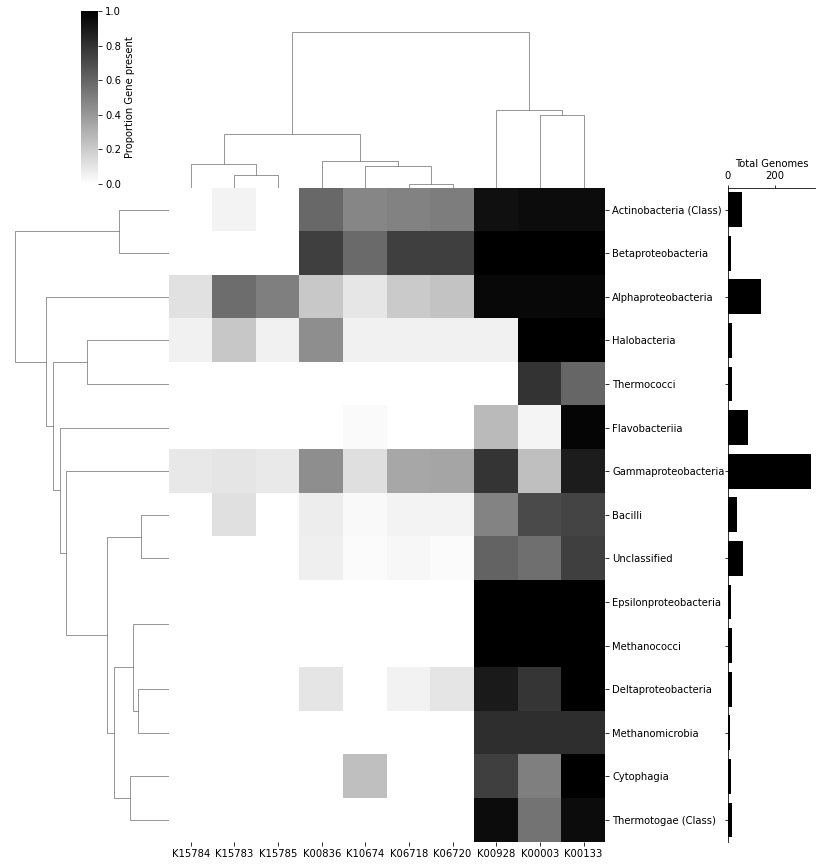

In [37]:
division_bact, total_bac_group =bact_groupby(df_bact, level='class')
create_cluster_bar(division_bact, total_bac_group, genome=True, cutoff=True, c=10)

In [38]:
pathway_bact_df = pd.DataFrame(index=df_bact.index)

for key in pathways:
    keggs = pathways[key]
    ii  = df_bact.loc[df_bact[keggs].sum(axis=1)==len(keggs)].index
    pathway_bact_df.loc[ii,key]=1
pathway_bact_df=pathway_bact_df.fillna(0)

Index(['Actinoalloteichus', 'Alcanivorax', 'Aliivibrio', 'Altererythrobacter',
       'Alteromonas', 'Brucella', 'Celeribacter', 'Cycloclasticus',
       'Halomonas', 'Maribacter', 'Marinobacter', 'Marinomonas',
       'Mycobacterium', 'Nitrosococcus', 'Nitrosopumilus', 'Octadecabacter',
       'Phaeobacter', 'Photobacterium', 'Pseudoalteromonas', 'Pseudomonas',
       'Rhodococcus', 'Rhodovulum', 'Ruegeria', 'Shewanella', 'Streptomyces',
       'Sulfitobacter', 'Thalassolituus', 'Unclassified', 'Vibrio'],
      dtype='object', name='genus')


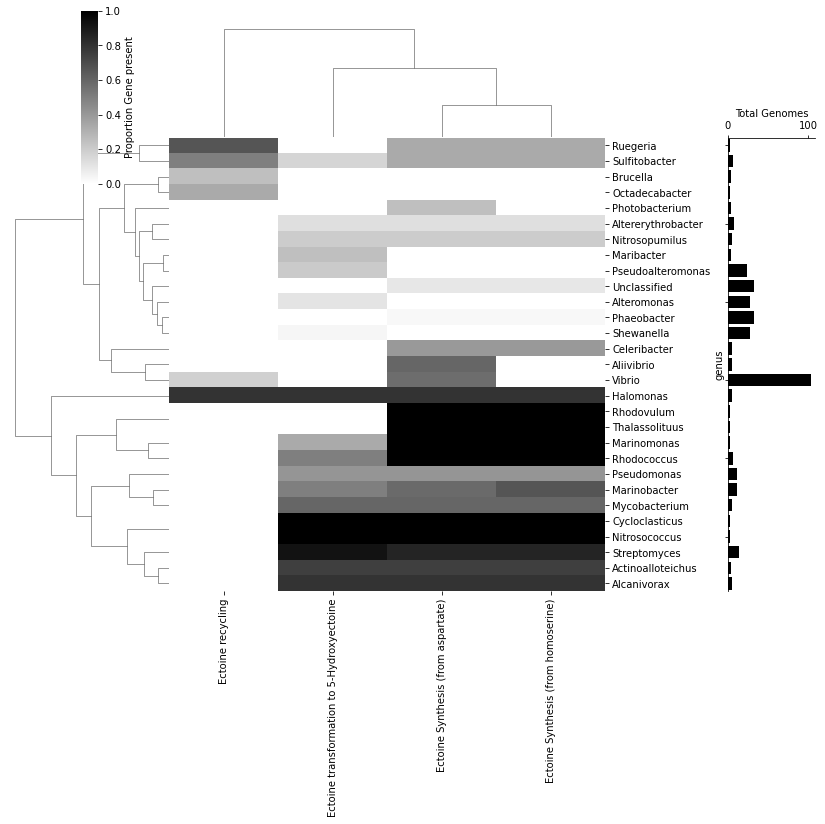

In [39]:
grouped_bact, total_bac_group  = bact_groupby(pathway_bact_df, level='genus', normalized=True)
create_cluster_bar(grouped_bact, total_bac_group, dropzero=True, genome=True, cutoff=True, c=2,)

In [40]:
ss=grouped_bact[grouped_bact['Ectoine Synthesis (from aspartate)']>0].index

In [41]:
pd.DataFrame(total_bac_group).loc[ss]

,alt_elev
genus,
Acinetobacter,1
Actinoalloteichus,4
Agarivorans,1
Alcaligenes,2
Alcanivorax,5
...,...
Thiomicrospira,2
Unclassified,32
Vibrio,103


# MMETSP 

Text(0, 0.5, 'Proportion abundance across MMETSP')

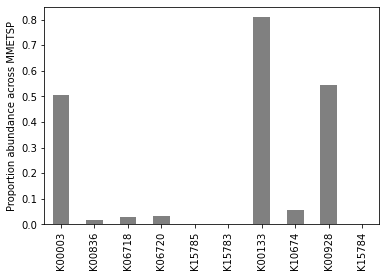

In [42]:
ax = (df_mmetsp.sum()/len(df_mmetsp)).plot(kind = 'bar', color='gray')
ax.set_ylabel('Proportion abundance across MMETSP')


In [43]:
mmetsp_taxonomy

,ORDER,CYVERSE_PATH,Source_ID_dup,REF_STATUS,Strain,Supergroup,Division,Class,Order,Family,Genus,Species,Notes
Source_ID,,,,,,,,,,,,,
MMETSP0290,150.0,2225.0,MMETSP0290,Clean,CCMP2878,Alveolata,Apicomplexa,Colpodellidea,Colpodellida,Chromeraceae,Chromera,Chromera velia,Curated by J. del Campo (PR2)
MMETSP0288,149.0,2224.0,MMETSP0288,Clean,CCMP3155,Alveolata,Apicomplexa,Colpodellidea,Vitrelladida,Vitrellaceae,Vitrella,Vitrella brassicaformis,Adl et al. 2019; Curated by J. del Campo and V...
MMETSP1451,659.0,2282.0,MMETSP1451,Clean,CCMP3346,Alveolata,Apicomplexa,Colpodellidea,Vitrelladida,Vitrellaceae,Vitrella,Vitrella brassicaformis,Adl et al. 2019; Curated by J. del Campo and V...
MMETSP0372,183.0,1822.0,MMETSP0372,Clean,Grappler Inlet BC,Alveolata,Apicomplexa,Gregarinomorphea,Eugregarinorida,Lecudinidae,Lankesteria,Lankesteria abbottii,Adl et al. 2019; Curated by J. del Campo (PR2)
MMETSP0125,75.0,1740.0,MMETSP0125,Clean,ATCC 50986,Alveolata,Ciliophora,Colpodea,Colpodea_X,Cyrtolophosidida,Aristerostoma,Aristerostoma sp.,Ciliophora EukRef curation Boscaro V.; previou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MMETSP0990,405.0,1938.0,MMETSP0990,Clean,CCMP2098,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Dictyochophyceae_XX,Uncertain,Uncertain,Not described; listed as Dictyochophyceae
MMETSP0991,406.0,1943.0,MMETSP0991,Clean,CCMP2098,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Dictyochophyceae_XX,Uncertain,Uncertain,Not described; listed as Dictyochophyceae
MMETSP0992,407.0,1944.0,MMETSP0992,Clean,CCMP2098,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Dictyochophyceae_XX,Uncertain,Uncertain,Not described; listed as Dictyochophyceae


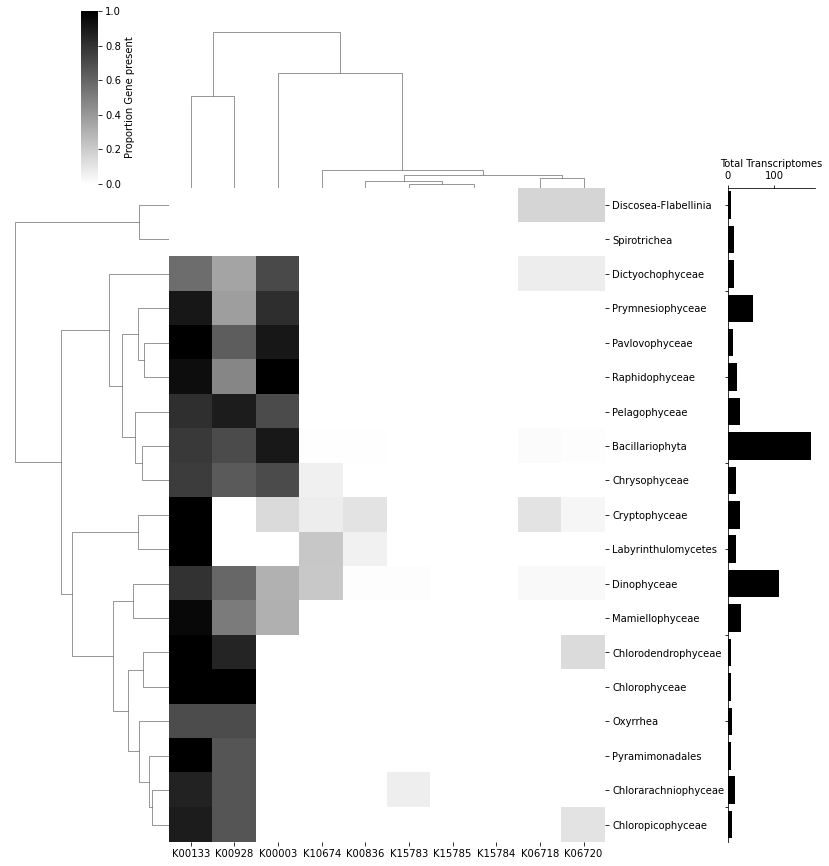

In [44]:
grouped_MMETSP, total_per_group  = MMETSP_groupby(df_mmetsp, 'Class', normalized=True)
create_cluster_bar(grouped_MMETSP, total_per_group,cutoff=True)


In [45]:
mmetsp_taxonomy

,ORDER,CYVERSE_PATH,Source_ID_dup,REF_STATUS,Strain,Supergroup,Division,Class,Order,Family,Genus,Species,Notes
Source_ID,,,,,,,,,,,,,
MMETSP0290,150.0,2225.0,MMETSP0290,Clean,CCMP2878,Alveolata,Apicomplexa,Colpodellidea,Colpodellida,Chromeraceae,Chromera,Chromera velia,Curated by J. del Campo (PR2)
MMETSP0288,149.0,2224.0,MMETSP0288,Clean,CCMP3155,Alveolata,Apicomplexa,Colpodellidea,Vitrelladida,Vitrellaceae,Vitrella,Vitrella brassicaformis,Adl et al. 2019; Curated by J. del Campo and V...
MMETSP1451,659.0,2282.0,MMETSP1451,Clean,CCMP3346,Alveolata,Apicomplexa,Colpodellidea,Vitrelladida,Vitrellaceae,Vitrella,Vitrella brassicaformis,Adl et al. 2019; Curated by J. del Campo and V...
MMETSP0372,183.0,1822.0,MMETSP0372,Clean,Grappler Inlet BC,Alveolata,Apicomplexa,Gregarinomorphea,Eugregarinorida,Lecudinidae,Lankesteria,Lankesteria abbottii,Adl et al. 2019; Curated by J. del Campo (PR2)
MMETSP0125,75.0,1740.0,MMETSP0125,Clean,ATCC 50986,Alveolata,Ciliophora,Colpodea,Colpodea_X,Cyrtolophosidida,Aristerostoma,Aristerostoma sp.,Ciliophora EukRef curation Boscaro V.; previou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MMETSP0990,405.0,1938.0,MMETSP0990,Clean,CCMP2098,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Dictyochophyceae_XX,Uncertain,Uncertain,Not described; listed as Dictyochophyceae
MMETSP0991,406.0,1943.0,MMETSP0991,Clean,CCMP2098,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Dictyochophyceae_XX,Uncertain,Uncertain,Not described; listed as Dictyochophyceae
MMETSP0992,407.0,1944.0,MMETSP0992,Clean,CCMP2098,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Dictyochophyceae_XX,Uncertain,Uncertain,Not described; listed as Dictyochophyceae


In [46]:
pathway_mmetsp_df = pd.DataFrame(index=df_mmetsp.index)

for key in pathways:
    keggs = pathways[key]
    ii  = df_mmetsp.loc[df_mmetsp[keggs].sum(axis=1)==len(keggs)].index
    pathway_mmetsp_df.loc[ii,key]=1
pathway_mmetsp_df=pathway_mmetsp_df.fillna(0)

Index(['Bacillariophyta', 'Bicoecea', 'Chrysophyceae', 'Cryptophyceae',
       'Dinophyceae', 'Globothalamea', 'Labyrinthulomycetes', 'Lobosa_X',
       'Nephroselmidophyceae', 'Tubothalamea', 'Tubulinea'],
      dtype='object', name='Class')


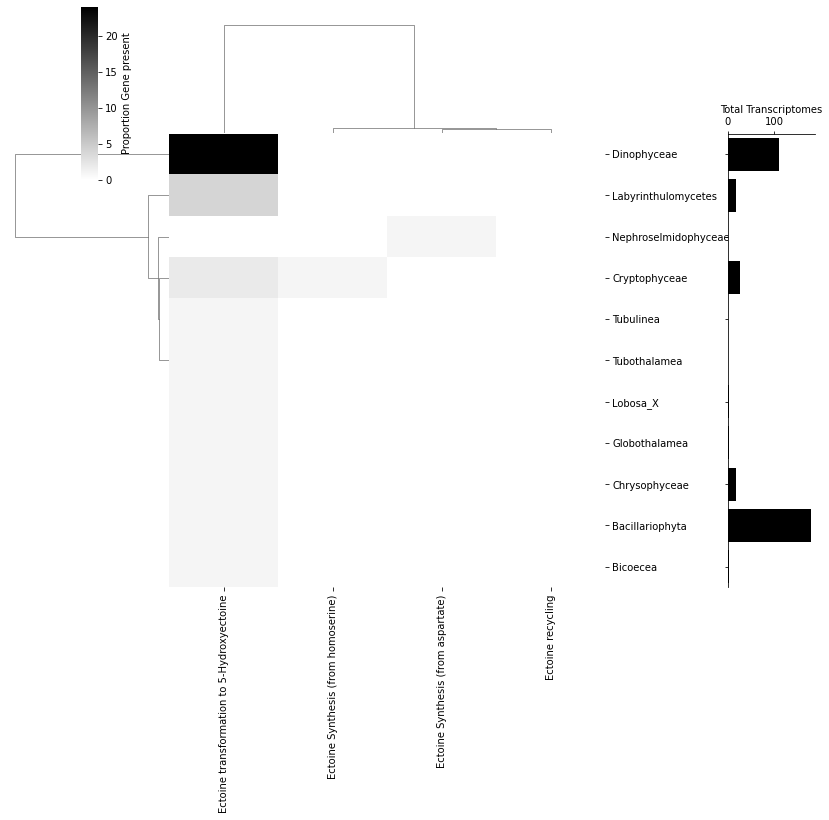

In [47]:
grouped_MMETSP, total_per_group  = MMETSP_groupby(pathway_mmetsp_df, 'Class', normalized=False)
create_cluster_bar(grouped_MMETSP, total_per_group, dropzero=True)

Text(0.5, 1.0, 'ectoine')

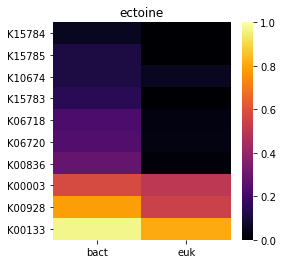

In [48]:
comp_df = pd.DataFrame()
comp_df['bact']=(df_bact.sum()/len(df_bact))
comp_df['euk']=(df_mmetsp.sum()/len(df_mmetsp))
comp_df = comp_df.sort_values(by='bact')
fig, ax = plt.subplots(1)
fig.set_size_inches(4,4)
sns.heatmap( data= comp_df, vmin=0., vmax=1., cmap='inferno')
ax.set_title('ectoine')